<a href="https://colab.research.google.com/github/HurleyJames/GoogleColabExercise/blob/master/AI_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 56.67 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


In [3]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/dumbbell/n03255030_11029....,6
1,imagenet10/train_set/baboon/n02486410_3577.JPEG,0
2,imagenet10/train_set/banana/n07753592_787.JPEG,1
3,imagenet10/train_set/banana/n07753592_580.JPEG,1
4,imagenet10/train_set/banana/n07753592_7598.JPEG,1


In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [10]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:40<00:00, 223.62it/s]


(224, 224, 3, 9000)
normMean = [0.5228344, 0.47988218, 0.40605018]
normStd = [0.29770824, 0.28884, 0.31178245]


In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10
# 测试集
# test_split = 0.20

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)
# 测试集大小
# test_size = int(len(data_df)*test_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

创建数据集

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=10,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=15,
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=30,
    shuffle=False,
    num_workers=2
)

In [14]:
len(train_loader)

630

In [15]:
len(valid_loader)

60

In [16]:
len(test_loader)

60

# CNN网络

In [0]:
train = []
valid = []
train2 = []
train3 = []
train4 = []
train5 = []
valid2 = []
valid3 = []
valid4 = []
valid5 = []

测试设备是否支持GPU

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 2层卷积层

In [19]:
# Convolutional neural network
class ConvNet2(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )
        
        # second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # 2-layer
        self.fc1 = nn.Linear(24*62*62, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)

        # !!!
        x = x.view(x.size(0), -1) 
        # x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        # x = nn.functional.log_softmax(x, dim=1)

        return x

    def retrieve_features(self, x):
        x = self.conv1[0](x)
        feature_map1 = x
        x = self.conv2[0](x)
        feature_map2 = x

        return (feature_map1, feature_map2)

model2 = ConvNet2()
print(model2)

ConvNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### 3层卷积层

In [20]:
# Convolutional neural network
class ConvNet3(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )
        
        # second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # 3-layer
        self.fc1 = nn.Linear(32*29*29, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # !!!
        x = x.view(x.size(0), -1) 
        # x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        # x = nn.functional.log_softmax(x, dim=1)

        return x

    def retrieve_features(self, x):
        x = self.conv1[0](x)
        feature_map1 = x
        x = self.conv2[0](x)
        feature_map2 = x
        x = self.conv3[0](x)
        feature_map3 = x

        return (feature_map1, feature_map2, feature_map3)

model3 = ConvNet3()
print(model3)

ConvNet3(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### 4层卷积层

In [21]:
# Convolutional neural network
class ConvNet4(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet4, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )
        
        # second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # fourth layer
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # 4-layer
        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # !!!
        x = x.view(x.size(0), -1) 
        # x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        # x = nn.functional.log_softmax(x, dim=1)

        return x

    def retrieve_features(self, x):
        x = self.conv1[0](x)
        feature_map1 = x
        x = self.conv2[0](x)
        feature_map2 = x
        x = self.conv3[0](x)
        feature_map3 = x
        x = self.conv4[0](x)
        feature_map4 = x

        return (feature_map1, feature_map2, feature_map3, feature_map4)

model4 = ConvNet4()
print(model4)

ConvNet4(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_f

### 5层卷积层

In [22]:
# Convolutional neural network
class ConvNet5(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )
        
        # second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # fourth layer
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # fifth layer
        self.conv5 = nn.Sequential(
            nn.Conv2d(40, 48, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # 5-layer
        self.fc1 = nn.Linear(48*5*5, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # !!!
        x = x.view(x.size(0), -1) 
        # x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        # x = nn.functional.log_softmax(x, dim=1)

        return x

    def retrieve_features(self, x):
        x = self.conv1[0](x)
        feature_map1 = x
        x = self.conv2[0](x)
        feature_map2 = x
        x = self.conv3[0](x)
        feature_map3 = x
        x = self.conv4[0](x)
        feature_map4 = x
        x = self.conv5[0](x)
        feature_map5 = x

        return (feature_map1, feature_map2, feature_map3, feature_map4, feature_map5)

model5 = ConvNet5()
print(model5)

ConvNet5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv5): Sequential(
    (0): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
 

### 定义优化器和损失函数

In [0]:
from torch import optim

torch.manual_seed(0)

# 四个优化器分别对应四个模型
optimizer2 = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)
optimizer3 = optim.SGD(model3.parameters(), lr = 0.001, momentum = 0.9)
optimizer4 = optim.SGD(model4.parameters(), lr = 0.001, momentum = 0.9)
optimizer5 = optim.SGD(model5.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

将模型放在GPU上

In [24]:
model2.to(device)

ConvNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=92256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
model3.to(device)

ConvNet3(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=26912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [26]:
model4.to(device)

ConvNet4(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_f

In [27]:
model5.to(device)

ConvNet5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (conv5): Sequential(
    (0): Conv2d(40, 48, kernel_size=(4, 4), stride=(1, 1))
 

### 训练网络

可视化卷积核方法

In [0]:
def filter_visual():
  figure = plt.figure(figsize = (15, 15))
  k = 0

  for i in range(16):
    
    filter_mix = np.zeros(shape = [3,3])
    for j in range(3):
      k = k + 1
      figure.add_subplot(8, 6, k)
      filter_mix += model.conv1[0].weight.data.cpu().numpy()[ i, j, :, :]
      plt.imshow(filter_mix, cmap = "gray")
  plt.show()

训练轮数

In [0]:
EPOCH = 10

训练模型方法

In [0]:
def train_model(num_epochs, model, optimizer, flag):
    
    for (epoch) in range(num_epochs):
        if (epoch == 5 and flag == 1):
            filter_visual()
        running_loss = 0.0
        sum_running_loss = 0
        for i, data in enumerate(train_loader, 0):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # 把网络中所有可学习参数的梯度清零
            optimizer.zero_grad()
            # 计算损失
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # 反向传播
            loss.backward()

            # 更新参数
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print('Train Epoch / Batch [%d / %d] - Loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 100))
                train.append(running_loss / 100)
                sum_running_loss += running_loss / 100
                running_loss = 0.0
        # train.append(sum_running_loss / 3)
    print('Finished')    

验证模型方法

In [0]:
def valid_model(num_epochs, model, optimizer):
    
    for (epoch) in range(num_epochs):
        running_loss = 0.0
        sum_running_loss = 0
        for i, data in enumerate(valid_loader, 0):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('Valid Epoch / Batch [%d / %d] - Loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                valid.append(running_loss / 10)
                sum_running_loss += running_loss / 10
                running_loss = 0.0
        # train.append(sum_running_loss / 3)
    print('Finished')    

训练2层模型

In [32]:
model2.train()
train_model(EPOCH, model2, optimizer2, 0)
train2 = train
train = []

Train Epoch / Batch [1 / 100] - Loss: 2.212
Train Epoch / Batch [1 / 200] - Loss: 2.127
Train Epoch / Batch [1 / 300] - Loss: 2.009
Train Epoch / Batch [1 / 400] - Loss: 2.010
Train Epoch / Batch [1 / 500] - Loss: 1.893
Train Epoch / Batch [1 / 600] - Loss: 1.984
Train Epoch / Batch [2 / 100] - Loss: 1.846
Train Epoch / Batch [2 / 200] - Loss: 1.892
Train Epoch / Batch [2 / 300] - Loss: 1.807
Train Epoch / Batch [2 / 400] - Loss: 1.813
Train Epoch / Batch [2 / 500] - Loss: 1.859
Train Epoch / Batch [2 / 600] - Loss: 1.809
Train Epoch / Batch [3 / 100] - Loss: 1.711
Train Epoch / Batch [3 / 200] - Loss: 1.706
Train Epoch / Batch [3 / 300] - Loss: 1.707
Train Epoch / Batch [3 / 400] - Loss: 1.700
Train Epoch / Batch [3 / 500] - Loss: 1.682
Train Epoch / Batch [3 / 600] - Loss: 1.690
Train Epoch / Batch [4 / 100] - Loss: 1.545
Train Epoch / Batch [4 / 200] - Loss: 1.560
Train Epoch / Batch [4 / 300] - Loss: 1.505
Train Epoch / Batch [4 / 400] - Loss: 1.598
Train Epoch / Batch [4 / 500] - 

验证2层模型

In [33]:
model2.eval()
valid_model(EPOCH, model2, optimizer2)
valid2 = valid
valid = []

Valid Epoch / Batch [1 / 10] - Loss: 2.194
Valid Epoch / Batch [1 / 20] - Loss: 2.375
Valid Epoch / Batch [1 / 30] - Loss: 1.784
Valid Epoch / Batch [1 / 40] - Loss: 1.795
Valid Epoch / Batch [1 / 50] - Loss: 1.731
Valid Epoch / Batch [1 / 60] - Loss: 1.705
Valid Epoch / Batch [2 / 10] - Loss: 0.967
Valid Epoch / Batch [2 / 20] - Loss: 0.983
Valid Epoch / Batch [2 / 30] - Loss: 0.822
Valid Epoch / Batch [2 / 40] - Loss: 0.913
Valid Epoch / Batch [2 / 50] - Loss: 1.021
Valid Epoch / Batch [2 / 60] - Loss: 1.053
Valid Epoch / Batch [3 / 10] - Loss: 0.545
Valid Epoch / Batch [3 / 20] - Loss: 0.518
Valid Epoch / Batch [3 / 30] - Loss: 0.392
Valid Epoch / Batch [3 / 40] - Loss: 0.440
Valid Epoch / Batch [3 / 50] - Loss: 0.538
Valid Epoch / Batch [3 / 60] - Loss: 0.480
Valid Epoch / Batch [4 / 10] - Loss: 0.284
Valid Epoch / Batch [4 / 20] - Loss: 0.278
Valid Epoch / Batch [4 / 30] - Loss: 0.177
Valid Epoch / Batch [4 / 40] - Loss: 0.222
Valid Epoch / Batch [4 / 50] - Loss: 0.258
Valid Epoch

训练3层模型

In [34]:
model3.train()
train_model(EPOCH, model3, optimizer3, 0)
train3 = train
train = []

Train Epoch / Batch [1 / 100] - Loss: 2.270
Train Epoch / Batch [1 / 200] - Loss: 2.131
Train Epoch / Batch [1 / 300] - Loss: 2.094
Train Epoch / Batch [1 / 400] - Loss: 2.068
Train Epoch / Batch [1 / 500] - Loss: 1.976
Train Epoch / Batch [1 / 600] - Loss: 2.004
Train Epoch / Batch [2 / 100] - Loss: 1.963
Train Epoch / Batch [2 / 200] - Loss: 1.931
Train Epoch / Batch [2 / 300] - Loss: 1.966
Train Epoch / Batch [2 / 400] - Loss: 1.923
Train Epoch / Batch [2 / 500] - Loss: 1.966
Train Epoch / Batch [2 / 600] - Loss: 1.955
Train Epoch / Batch [3 / 100] - Loss: 1.916
Train Epoch / Batch [3 / 200] - Loss: 1.905
Train Epoch / Batch [3 / 300] - Loss: 1.856
Train Epoch / Batch [3 / 400] - Loss: 1.846
Train Epoch / Batch [3 / 500] - Loss: 1.832
Train Epoch / Batch [3 / 600] - Loss: 1.920
Train Epoch / Batch [4 / 100] - Loss: 1.842
Train Epoch / Batch [4 / 200] - Loss: 1.822
Train Epoch / Batch [4 / 300] - Loss: 1.877
Train Epoch / Batch [4 / 400] - Loss: 1.827
Train Epoch / Batch [4 / 500] - 

验证3层模型

In [35]:
model3.eval()
valid_model(EPOCH, model3, optimizer3)
valid3 = valid
valid = []

Valid Epoch / Batch [1 / 10] - Loss: 1.494
Valid Epoch / Batch [1 / 20] - Loss: 1.716
Valid Epoch / Batch [1 / 30] - Loss: 1.477
Valid Epoch / Batch [1 / 40] - Loss: 1.426
Valid Epoch / Batch [1 / 50] - Loss: 1.601
Valid Epoch / Batch [1 / 60] - Loss: 1.414
Valid Epoch / Batch [2 / 10] - Loss: 1.284
Valid Epoch / Batch [2 / 20] - Loss: 1.475
Valid Epoch / Batch [2 / 30] - Loss: 1.243
Valid Epoch / Batch [2 / 40] - Loss: 1.144
Valid Epoch / Batch [2 / 50] - Loss: 1.392
Valid Epoch / Batch [2 / 60] - Loss: 1.218
Valid Epoch / Batch [3 / 10] - Loss: 1.132
Valid Epoch / Batch [3 / 20] - Loss: 1.268
Valid Epoch / Batch [3 / 30] - Loss: 1.041
Valid Epoch / Batch [3 / 40] - Loss: 0.918
Valid Epoch / Batch [3 / 50] - Loss: 1.173
Valid Epoch / Batch [3 / 60] - Loss: 1.034
Valid Epoch / Batch [4 / 10] - Loss: 0.970
Valid Epoch / Batch [4 / 20] - Loss: 1.034
Valid Epoch / Batch [4 / 30] - Loss: 0.829
Valid Epoch / Batch [4 / 40] - Loss: 0.707
Valid Epoch / Batch [4 / 50] - Loss: 0.909
Valid Epoch

训练4层模型

In [36]:
model4.train()
train_model(EPOCH, model4, optimizer4, 0)
train4 = train
train = []

Train Epoch / Batch [1 / 100] - Loss: 2.303
Train Epoch / Batch [1 / 200] - Loss: 2.280
Train Epoch / Batch [1 / 300] - Loss: 2.253
Train Epoch / Batch [1 / 400] - Loss: 2.217
Train Epoch / Batch [1 / 500] - Loss: 2.091
Train Epoch / Batch [1 / 600] - Loss: 2.050
Train Epoch / Batch [2 / 100] - Loss: 1.996
Train Epoch / Batch [2 / 200] - Loss: 2.066
Train Epoch / Batch [2 / 300] - Loss: 2.055
Train Epoch / Batch [2 / 400] - Loss: 2.030
Train Epoch / Batch [2 / 500] - Loss: 2.017
Train Epoch / Batch [2 / 600] - Loss: 1.978
Train Epoch / Batch [3 / 100] - Loss: 1.940
Train Epoch / Batch [3 / 200] - Loss: 1.952
Train Epoch / Batch [3 / 300] - Loss: 1.995
Train Epoch / Batch [3 / 400] - Loss: 1.941
Train Epoch / Batch [3 / 500] - Loss: 1.955
Train Epoch / Batch [3 / 600] - Loss: 1.967
Train Epoch / Batch [4 / 100] - Loss: 1.965
Train Epoch / Batch [4 / 200] - Loss: 1.887
Train Epoch / Batch [4 / 300] - Loss: 1.937
Train Epoch / Batch [4 / 400] - Loss: 1.941
Train Epoch / Batch [4 / 500] - 

验证4层模型

In [37]:
model4.eval()
valid_model(EPOCH, model4, optimizer4)
valid4 = valid
valid = []

Valid Epoch / Batch [1 / 10] - Loss: 1.498
Valid Epoch / Batch [1 / 20] - Loss: 1.704
Valid Epoch / Batch [1 / 30] - Loss: 1.446
Valid Epoch / Batch [1 / 40] - Loss: 1.431
Valid Epoch / Batch [1 / 50] - Loss: 1.626
Valid Epoch / Batch [1 / 60] - Loss: 1.459
Valid Epoch / Batch [2 / 10] - Loss: 1.396
Valid Epoch / Batch [2 / 20] - Loss: 1.587
Valid Epoch / Batch [2 / 30] - Loss: 1.338
Valid Epoch / Batch [2 / 40] - Loss: 1.279
Valid Epoch / Batch [2 / 50] - Loss: 1.580
Valid Epoch / Batch [2 / 60] - Loss: 1.361
Valid Epoch / Batch [3 / 10] - Loss: 1.323
Valid Epoch / Batch [3 / 20] - Loss: 1.520
Valid Epoch / Batch [3 / 30] - Loss: 1.284
Valid Epoch / Batch [3 / 40] - Loss: 1.186
Valid Epoch / Batch [3 / 50] - Loss: 1.526
Valid Epoch / Batch [3 / 60] - Loss: 1.289
Valid Epoch / Batch [4 / 10] - Loss: 1.280
Valid Epoch / Batch [4 / 20] - Loss: 1.452
Valid Epoch / Batch [4 / 30] - Loss: 1.233
Valid Epoch / Batch [4 / 40] - Loss: 1.106
Valid Epoch / Batch [4 / 50] - Loss: 1.465
Valid Epoch

训练5层模型

In [38]:
model5.train()
train_model(EPOCH, model5, optimizer5, 0)
train5 = train
train = []

Train Epoch / Batch [1 / 100] - Loss: 2.298
Train Epoch / Batch [1 / 200] - Loss: 2.301
Train Epoch / Batch [1 / 300] - Loss: 2.284
Train Epoch / Batch [1 / 400] - Loss: 2.281
Train Epoch / Batch [1 / 500] - Loss: 2.260
Train Epoch / Batch [1 / 600] - Loss: 2.243
Train Epoch / Batch [2 / 100] - Loss: 2.214
Train Epoch / Batch [2 / 200] - Loss: 2.199
Train Epoch / Batch [2 / 300] - Loss: 2.148
Train Epoch / Batch [2 / 400] - Loss: 2.121
Train Epoch / Batch [2 / 500] - Loss: 2.113
Train Epoch / Batch [2 / 600] - Loss: 2.128
Train Epoch / Batch [3 / 100] - Loss: 2.098
Train Epoch / Batch [3 / 200] - Loss: 2.031
Train Epoch / Batch [3 / 300] - Loss: 2.067
Train Epoch / Batch [3 / 400] - Loss: 2.070
Train Epoch / Batch [3 / 500] - Loss: 2.020
Train Epoch / Batch [3 / 600] - Loss: 2.056
Train Epoch / Batch [4 / 100] - Loss: 2.045
Train Epoch / Batch [4 / 200] - Loss: 1.990
Train Epoch / Batch [4 / 300] - Loss: 1.974
Train Epoch / Batch [4 / 400] - Loss: 2.016
Train Epoch / Batch [4 / 500] - 

验证5层模型

In [39]:
model5.eval()
valid_model(EPOCH, model5, optimizer5)
valid5 = valid
valid = []

Valid Epoch / Batch [1 / 10] - Loss: 1.723
Valid Epoch / Batch [1 / 20] - Loss: 1.870
Valid Epoch / Batch [1 / 30] - Loss: 1.776
Valid Epoch / Batch [1 / 40] - Loss: 1.687
Valid Epoch / Batch [1 / 50] - Loss: 1.824
Valid Epoch / Batch [1 / 60] - Loss: 1.664
Valid Epoch / Batch [2 / 10] - Loss: 1.611
Valid Epoch / Batch [2 / 20] - Loss: 1.820
Valid Epoch / Batch [2 / 30] - Loss: 1.704
Valid Epoch / Batch [2 / 40] - Loss: 1.622
Valid Epoch / Batch [2 / 50] - Loss: 1.786
Valid Epoch / Batch [2 / 60] - Loss: 1.612
Valid Epoch / Batch [3 / 10] - Loss: 1.573
Valid Epoch / Batch [3 / 20] - Loss: 1.785
Valid Epoch / Batch [3 / 30] - Loss: 1.650
Valid Epoch / Batch [3 / 40] - Loss: 1.569
Valid Epoch / Batch [3 / 50] - Loss: 1.754
Valid Epoch / Batch [3 / 60] - Loss: 1.574
Valid Epoch / Batch [4 / 10] - Loss: 1.547
Valid Epoch / Batch [4 / 20] - Loss: 1.754
Valid Epoch / Batch [4 / 30] - Loss: 1.605
Valid Epoch / Batch [4 / 40] - Loss: 1.520
Valid Epoch / Batch [4 / 50] - Loss: 1.718
Valid Epoch

计算准确率方法

In [0]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

def accuracy(model, loader):
    correct = 0
    total = 0

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    labels_true = np.array([], dtype=int)
    labels_pred = np.array([], dtype=int)

    # Why don't we need gradients? What happens if we do include gradients?
    with torch.no_grad():
        
        # Iterate over the test set
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            labels_true = np.append(labels_true, labels.cpu().numpy())
            labels_pred = np.append(labels_pred, predicted.cpu().numpy())

            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    print("correct: %d" % correct)
    print("total: %d" % total)
    print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

    for i in range(10):
        print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

    total = 0
    correct = 0

定义绘制混淆矩阵方法

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #fmt = '.2f' if normalize else 'd'
    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100)) 

2层模型的准确率

In [42]:
accuracy(model2, train_loader)
accuracy(model2, valid_loader)
accuracy(model2, test_loader)

correct: 5872
total: 6300
Accuracy of the network on the images: 93 %
Accuracy of baboon: 98 %
Accuracy of banana: 83 %
Accuracy of canoe: 96 %
Accuracy of   cat: 96 %
Accuracy of  desk: 94 %
Accuracy of drill: 93 %
Accuracy of dumbbell: 86 %
Accuracy of football: 92 %
Accuracy of   mug: 94 %
Accuracy of orange: 95 %
correct: 900
total: 900
Accuracy of the network on the images: 100 %
Accuracy of baboon: 100 %
Accuracy of banana: 100 %
Accuracy of canoe: 100 %
Accuracy of   cat: 100 %
Accuracy of  desk: 100 %
Accuracy of drill: 100 %
Accuracy of dumbbell: 100 %
Accuracy of football: 100 %
Accuracy of   mug: 100 %
Accuracy of orange: 100 %
correct: 867
total: 1800
Accuracy of the network on the images: 48 %
Accuracy of baboon: 67 %
Accuracy of banana: 42 %
Accuracy of canoe: 62 %
Accuracy of   cat: 49 %
Accuracy of  desk: 50 %
Accuracy of drill: 38 %
Accuracy of dumbbell: 20 %
Accuracy of football: 43 %
Accuracy of   mug: 41 %
Accuracy of orange: 83 %


In [43]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model2(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 867
total: 1800
Accuracy of the network on the images: 48 %
Accuracy of baboon: 67 %
Accuracy of banana: 42 %
Accuracy of canoe: 62 %
Accuracy of   cat: 49 %
Accuracy of  desk: 50 %
Accuracy of drill: 38 %
Accuracy of dumbbell: 20 %
Accuracy of football: 43 %
Accuracy of   mug: 41 %
Accuracy of orange: 83 %


打印二维数组

In [44]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[121.   2.   7.  34.   2.   1.   8.   2.   3.   0.]
 [ 12.  61.   5.  13.   9.   2.  12.  21.   8.  45.]
 [  8.   3.  90.   6.  25.   5.   5.  15.   8.   1.]
 [ 28.   2.  14. 104.   4.   5.  10.  12.   6.   0.]
 [  1.   3.  25.   4.  85.  12.   9.  11.  20.   3.]
 [  9.   5.   8.  16.  17.  68.  26.   8.  17.   3.]
 [  8.   3.   8.  13.  30.  21.  50.  12.  25.   3.]
 [ 24.   5.  22.  21.  11.   7.  22.  61.  12.   4.]
 [  9.   6.   9.   4.  19.   8.  19.  22.  85.  12.]
 [  0.  21.   1.   1.   2.   2.   1.   3.   3. 142.]]


绘制混淆矩阵

Normalized confusion matrix
[[121.   2.   7.  34.   2.   1.   8.   2.   3.   0.]
 [ 12.  61.   5.  13.   9.   2.  12.  21.   8.  45.]
 [  8.   3.  90.   6.  25.   5.   5.  15.   8.   1.]
 [ 28.   2.  14. 104.   4.   5.  10.  12.   6.   0.]
 [  1.   3.  25.   4.  85.  12.   9.  11.  20.   3.]
 [  9.   5.   8.  16.  17.  68.  26.   8.  17.   3.]
 [  8.   3.   8.  13.  30.  21.  50.  12.  25.   3.]
 [ 24.   5.  22.  21.  11.   7.  22.  61.  12.   4.]
 [  9.   6.   9.   4.  19.   8.  19.  22.  85.  12.]
 [  0.  21.   1.   1.   2.   2.   1.   3.   3. 142.]]


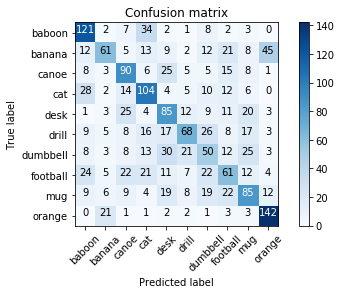

<Figure size 7200x7200 with 0 Axes>

In [45]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

3层模型的准确率

In [46]:
accuracy(model3, train_loader)
accuracy(model3, valid_loader)
accuracy(model3, test_loader)

correct: 3657
total: 6300
Accuracy of the network on the images: 58 %
Accuracy of baboon: 63 %
Accuracy of banana: 56 %
Accuracy of canoe: 62 %
Accuracy of   cat: 70 %
Accuracy of  desk: 31 %
Accuracy of drill: 61 %
Accuracy of dumbbell: 49 %
Accuracy of football: 58 %
Accuracy of   mug: 58 %
Accuracy of orange: 68 %
correct: 876
total: 900
Accuracy of the network on the images: 97 %
Accuracy of baboon: 98 %
Accuracy of banana: 98 %
Accuracy of canoe: 98 %
Accuracy of   cat: 100 %
Accuracy of  desk: 89 %
Accuracy of drill: 100 %
Accuracy of dumbbell: 100 %
Accuracy of football: 100 %
Accuracy of   mug: 100 %
Accuracy of orange: 94 %
correct: 798
total: 1800
Accuracy of the network on the images: 44 %
Accuracy of baboon: 52 %
Accuracy of banana: 47 %
Accuracy of canoe: 46 %
Accuracy of   cat: 57 %
Accuracy of  desk: 17 %
Accuracy of drill: 37 %
Accuracy of dumbbell: 23 %
Accuracy of football: 39 %
Accuracy of   mug: 37 %
Accuracy of orange: 63 %


In [47]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 809
total: 1800
Accuracy of the network on the images: 44 %
Accuracy of baboon: 70 %
Accuracy of banana: 51 %
Accuracy of canoe: 51 %
Accuracy of   cat: 55 %
Accuracy of  desk: 15 %
Accuracy of drill: 31 %
Accuracy of dumbbell: 20 %
Accuracy of football: 41 %
Accuracy of   mug: 31 %
Accuracy of orange: 66 %


打印二维数组

In [48]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[118.   2.   5.  44.   0.   0.   1.   7.   3.   0.]
 [  4.  92.   0.  11.   1.   1.   4.  31.  11.  33.]
 [  8.   4.  88.  16.   2.   4.   8.  26.  10.   0.]
 [ 43.   3.   4. 116.   0.   1.   0.  16.   1.   1.]
 [  3.   7.  28.   6.  28.   9.  23.  24.  39.   6.]
 [ 12.   5.  10.   9.   7.  55.  21.  19.  34.   5.]
 [ 21.   3.  10.  19.   9.   6.  43.  20.  38.   4.]
 [ 21.   6.  11.  28.   3.   5.   6.  85.  18.   6.]
 [ 13.  18.   6.  10.   4.   4.  16.  33.  74.  15.]
 [  1.  47.   1.   1.   0.   1.   0.  14.   1. 110.]]


绘制混淆矩阵

Normalized confusion matrix
[[118.   2.   5.  44.   0.   0.   1.   7.   3.   0.]
 [  4.  92.   0.  11.   1.   1.   4.  31.  11.  33.]
 [  8.   4.  88.  16.   2.   4.   8.  26.  10.   0.]
 [ 43.   3.   4. 116.   0.   1.   0.  16.   1.   1.]
 [  3.   7.  28.   6.  28.   9.  23.  24.  39.   6.]
 [ 12.   5.  10.   9.   7.  55.  21.  19.  34.   5.]
 [ 21.   3.  10.  19.   9.   6.  43.  20.  38.   4.]
 [ 21.   6.  11.  28.   3.   5.   6.  85.  18.   6.]
 [ 13.  18.   6.  10.   4.   4.  16.  33.  74.  15.]
 [  1.  47.   1.   1.   0.   1.   0.  14.   1. 110.]]


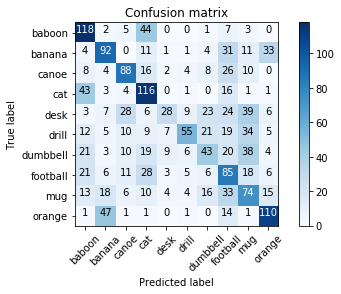

<Figure size 7200x7200 with 0 Axes>

In [49]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

4层模型的准确率

In [50]:
accuracy(model4, train_loader)
accuracy(model4, valid_loader)
accuracy(model4, test_loader)

correct: 3048
total: 6300
Accuracy of the network on the images: 48 %
Accuracy of baboon: 67 %
Accuracy of banana: 47 %
Accuracy of canoe: 56 %
Accuracy of   cat: 64 %
Accuracy of  desk: 17 %
Accuracy of drill: 42 %
Accuracy of dumbbell: 26 %
Accuracy of football: 45 %
Accuracy of   mug: 46 %
Accuracy of orange: 69 %
correct: 659
total: 900
Accuracy of the network on the images: 73 %
Accuracy of baboon: 91 %
Accuracy of banana: 77 %
Accuracy of canoe: 77 %
Accuracy of   cat: 81 %
Accuracy of  desk: 33 %
Accuracy of drill: 65 %
Accuracy of dumbbell: 56 %
Accuracy of football: 83 %
Accuracy of   mug: 79 %
Accuracy of orange: 82 %
correct: 809
total: 1800
Accuracy of the network on the images: 44 %
Accuracy of baboon: 70 %
Accuracy of banana: 51 %
Accuracy of canoe: 51 %
Accuracy of   cat: 55 %
Accuracy of  desk: 15 %
Accuracy of drill: 31 %
Accuracy of dumbbell: 20 %
Accuracy of football: 41 %
Accuracy of   mug: 31 %
Accuracy of orange: 66 %


In [51]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 809
total: 1800
Accuracy of the network on the images: 44 %
Accuracy of baboon: 70 %
Accuracy of banana: 51 %
Accuracy of canoe: 51 %
Accuracy of   cat: 55 %
Accuracy of  desk: 15 %
Accuracy of drill: 31 %
Accuracy of dumbbell: 20 %
Accuracy of football: 41 %
Accuracy of   mug: 31 %
Accuracy of orange: 66 %


打印二维数组

In [52]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[118.   2.   5.  44.   0.   0.   1.   7.   3.   0.]
 [  4.  92.   0.  11.   1.   1.   4.  31.  11.  33.]
 [  8.   4.  88.  16.   2.   4.   8.  26.  10.   0.]
 [ 43.   3.   4. 116.   0.   1.   0.  16.   1.   1.]
 [  3.   7.  28.   6.  28.   9.  23.  24.  39.   6.]
 [ 12.   5.  10.   9.   7.  55.  21.  19.  34.   5.]
 [ 21.   3.  10.  19.   9.   6.  43.  20.  38.   4.]
 [ 21.   6.  11.  28.   3.   5.   6.  85.  18.   6.]
 [ 13.  18.   6.  10.   4.   4.  16.  33.  74.  15.]
 [  1.  47.   1.   1.   0.   1.   0.  14.   1. 110.]]


绘制混淆矩阵

Normalized confusion matrix
[[118.   2.   5.  44.   0.   0.   1.   7.   3.   0.]
 [  4.  92.   0.  11.   1.   1.   4.  31.  11.  33.]
 [  8.   4.  88.  16.   2.   4.   8.  26.  10.   0.]
 [ 43.   3.   4. 116.   0.   1.   0.  16.   1.   1.]
 [  3.   7.  28.   6.  28.   9.  23.  24.  39.   6.]
 [ 12.   5.  10.   9.   7.  55.  21.  19.  34.   5.]
 [ 21.   3.  10.  19.   9.   6.  43.  20.  38.   4.]
 [ 21.   6.  11.  28.   3.   5.   6.  85.  18.   6.]
 [ 13.  18.   6.  10.   4.   4.  16.  33.  74.  15.]
 [  1.  47.   1.   1.   0.   1.   0.  14.   1. 110.]]


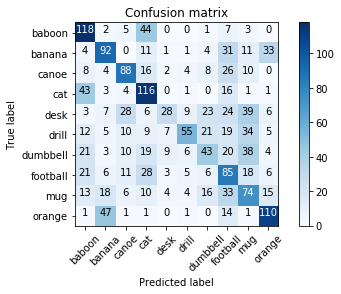

<Figure size 7200x7200 with 0 Axes>

In [53]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

5层模型的准确率

In [54]:
accuracy(model5, train_loader)
accuracy(model5, valid_loader)
accuracy(model5, test_loader)

correct: 2526
total: 6300
Accuracy of the network on the images: 40 %
Accuracy of baboon: 78 %
Accuracy of banana: 31 %
Accuracy of canoe: 49 %
Accuracy of   cat: 32 %
Accuracy of  desk: 20 %
Accuracy of drill: 37 %
Accuracy of dumbbell: 15 %
Accuracy of football: 23 %
Accuracy of   mug: 46 %
Accuracy of orange: 65 %
correct: 451
total: 900
Accuracy of the network on the images: 50 %
Accuracy of baboon: 81 %
Accuracy of banana: 49 %
Accuracy of canoe: 64 %
Accuracy of   cat: 35 %
Accuracy of  desk: 23 %
Accuracy of drill: 50 %
Accuracy of dumbbell: 26 %
Accuracy of football: 37 %
Accuracy of   mug: 66 %
Accuracy of orange: 76 %
correct: 665
total: 1800
Accuracy of the network on the images: 36 %
Accuracy of baboon: 81 %
Accuracy of banana: 27 %
Accuracy of canoe: 51 %
Accuracy of   cat: 27 %
Accuracy of  desk: 19 %
Accuracy of drill: 29 %
Accuracy of dumbbell: 10 %
Accuracy of football: 20 %
Accuracy of   mug: 37 %
Accuracy of orange: 57 %


In [55]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model5(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 665
total: 1800
Accuracy of the network on the images: 36 %
Accuracy of baboon: 81 %
Accuracy of banana: 27 %
Accuracy of canoe: 51 %
Accuracy of   cat: 27 %
Accuracy of  desk: 19 %
Accuracy of drill: 29 %
Accuracy of dumbbell: 10 %
Accuracy of football: 20 %
Accuracy of   mug: 37 %
Accuracy of orange: 57 %


打印二维数组

In [56]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[131.   2.   4.  22.   0.   1.   5.   5.  10.   0.]
 [ 11.  56.   6.  11.   2.   4.   1.  11.  17.  69.]
 [ 16.   3.  84.  21.   7.   2.   0.  18.  14.   1.]
 [ 81.   8.   6.  54.   2.   1.   5.  15.  13.   0.]
 [  3.  10.  39.   7.  37.   8.   7.  25.  35.   2.]
 [ 12.   5.   6.  18.   4.  58.   8.  18.  43.   5.]
 [ 26.   7.  10.  17.  16.   6.  25.  16.  50.   0.]
 [ 42.  10.  11.  30.   9.   3.  10.  38.  33.   3.]
 [ 14.  14.  12.  19.   6.   2.  14.  22.  77.  13.]
 [  1.  56.   3.   1.   0.   0.   0.   5.   5. 105.]]


绘制混淆矩阵

Normalized confusion matrix
[[131.   2.   4.  22.   0.   1.   5.   5.  10.   0.]
 [ 11.  56.   6.  11.   2.   4.   1.  11.  17.  69.]
 [ 16.   3.  84.  21.   7.   2.   0.  18.  14.   1.]
 [ 81.   8.   6.  54.   2.   1.   5.  15.  13.   0.]
 [  3.  10.  39.   7.  37.   8.   7.  25.  35.   2.]
 [ 12.   5.   6.  18.   4.  58.   8.  18.  43.   5.]
 [ 26.   7.  10.  17.  16.   6.  25.  16.  50.   0.]
 [ 42.  10.  11.  30.   9.   3.  10.  38.  33.   3.]
 [ 14.  14.  12.  19.   6.   2.  14.  22.  77.  13.]
 [  1.  56.   3.   1.   0.   0.   0.   5.   5. 105.]]


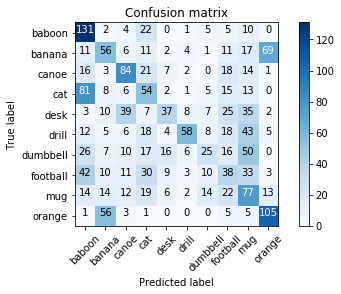

<Figure size 7200x7200 with 0 Axes>

In [57]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

绘制损失函数的方法

In [0]:
def draw_loss(train, valid):
    x = np.arange(0, 60)

    plt.figure()
    plt.plot(x, train, "r", "-", linewidth=1)

    plt.plot(x, valid, "b", ":", linewidth=1)

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("finding converge by loss")

2层模型的损失函数图

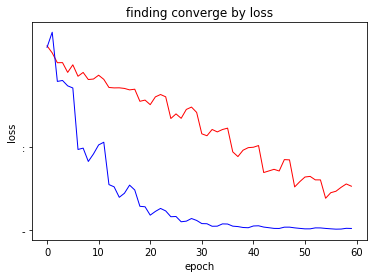

In [59]:
draw_loss(train2, valid2)

3层模型的损失函数图

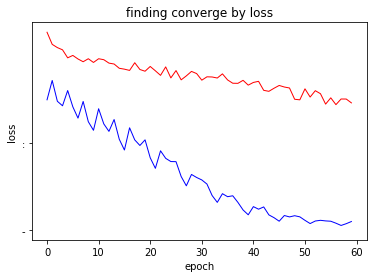

In [60]:
draw_loss(train3, valid3)

4层模型的损失函数图

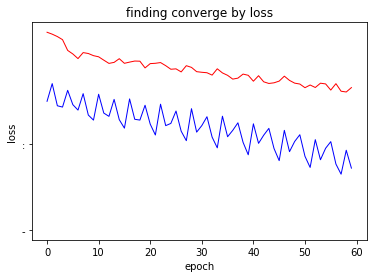

In [61]:
draw_loss(train4, valid4)

5层模型的损失函数图

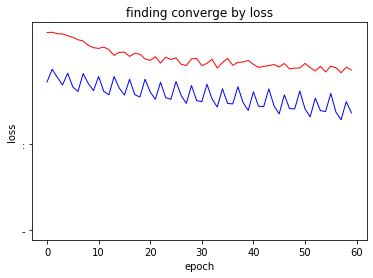

In [62]:
draw_loss(train5, valid5)

### 选取4层网络，并改变参数

In [63]:
# Convolutional neural network
class ReConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ReConvNet, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1)
        )
        
        # second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(24, 32, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # fourth layer
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 40, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # 4-layer
        self.fc1 = nn.Linear(40*13*13, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # !!!
        x = x.view(x.size(0), -1) 
        # x = x.reshape(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        # x = nn.functional.log_softmax(x, dim=1)

        return x

    def retrieve_features(self, x):
        x = self.conv1[0](x)
        feature_map1 = x
        x = self.conv2[0](x)
        feature_map2 = x
        x = self.conv3[0](x)
        feature_map3 = x
        x = self.conv4[0](x)
        feature_map4 = x

        return (feature_map1, feature_map2, feature_map3, feature_map4)

model = ReConvNet()
print(model)

ReConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_

定义优化器和损失函数

In [0]:
from torch import optim

torch.manual_seed(0)

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

将模型放在GPU上

In [65]:
model.to(device)

ReConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_

训练前的卷积核可视化

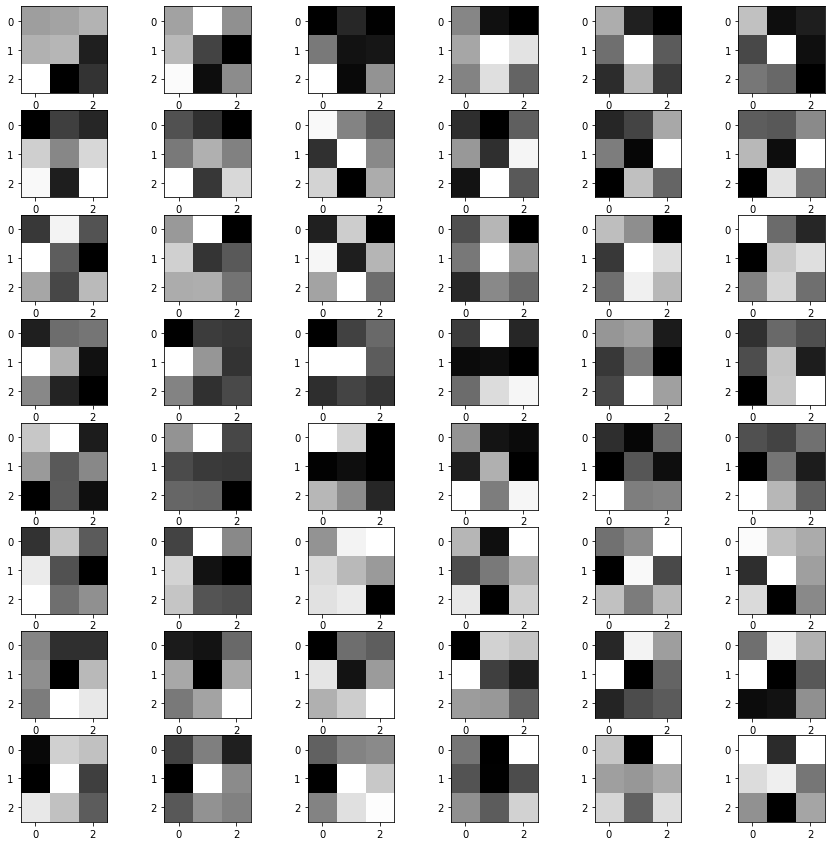

In [66]:
filter_visual()

In [0]:
reTrain = []
reValid = []

训练网络与训练中的卷积核可视化

Train Epoch / Batch [1 / 100] - Loss: 2.298
Train Epoch / Batch [1 / 200] - Loss: 2.281
Train Epoch / Batch [1 / 300] - Loss: 2.218
Train Epoch / Batch [1 / 400] - Loss: 2.069
Train Epoch / Batch [1 / 500] - Loss: 1.964
Train Epoch / Batch [1 / 600] - Loss: 2.030
Train Epoch / Batch [2 / 100] - Loss: 1.929
Train Epoch / Batch [2 / 200] - Loss: 1.935
Train Epoch / Batch [2 / 300] - Loss: 1.913
Train Epoch / Batch [2 / 400] - Loss: 1.901
Train Epoch / Batch [2 / 500] - Loss: 1.956
Train Epoch / Batch [2 / 600] - Loss: 1.876
Train Epoch / Batch [3 / 100] - Loss: 1.821
Train Epoch / Batch [3 / 200] - Loss: 1.816
Train Epoch / Batch [3 / 300] - Loss: 1.875
Train Epoch / Batch [3 / 400] - Loss: 1.842
Train Epoch / Batch [3 / 500] - Loss: 1.719
Train Epoch / Batch [3 / 600] - Loss: 1.785
Train Epoch / Batch [4 / 100] - Loss: 1.707
Train Epoch / Batch [4 / 200] - Loss: 1.710
Train Epoch / Batch [4 / 300] - Loss: 1.671
Train Epoch / Batch [4 / 400] - Loss: 1.729
Train Epoch / Batch [4 / 500] - 

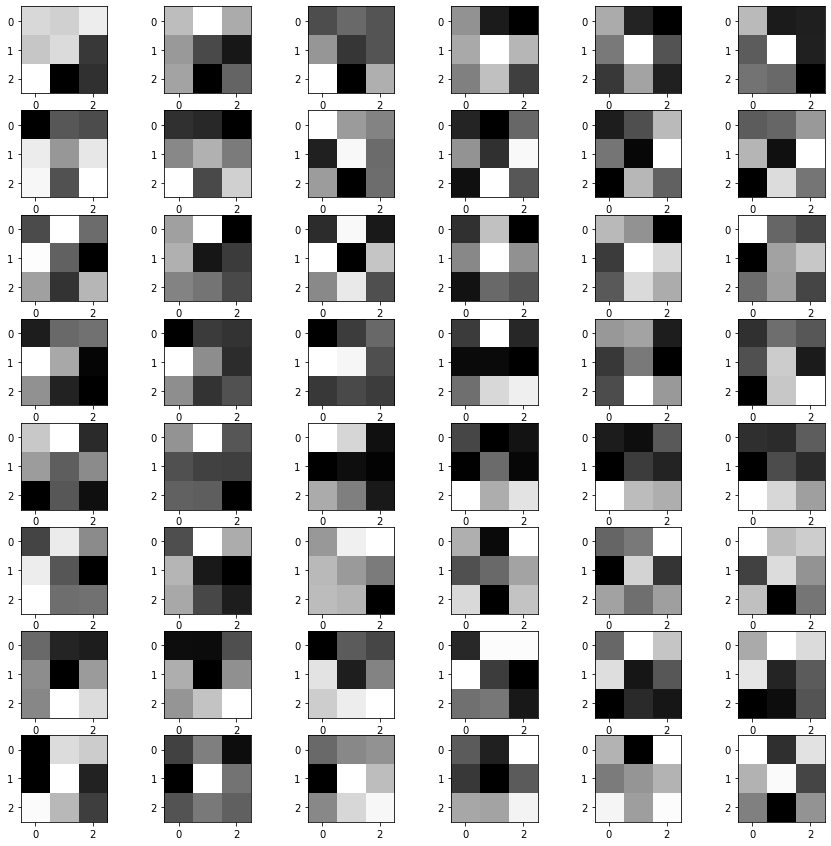

Train Epoch / Batch [6 / 100] - Loss: 1.579
Train Epoch / Batch [6 / 200] - Loss: 1.523
Train Epoch / Batch [6 / 300] - Loss: 1.586
Train Epoch / Batch [6 / 400] - Loss: 1.616
Train Epoch / Batch [6 / 500] - Loss: 1.580
Train Epoch / Batch [6 / 600] - Loss: 1.493
Train Epoch / Batch [7 / 100] - Loss: 1.526
Train Epoch / Batch [7 / 200] - Loss: 1.484
Train Epoch / Batch [7 / 300] - Loss: 1.528
Train Epoch / Batch [7 / 400] - Loss: 1.444
Train Epoch / Batch [7 / 500] - Loss: 1.453
Train Epoch / Batch [7 / 600] - Loss: 1.492
Train Epoch / Batch [8 / 100] - Loss: 1.443
Train Epoch / Batch [8 / 200] - Loss: 1.354
Train Epoch / Batch [8 / 300] - Loss: 1.425
Train Epoch / Batch [8 / 400] - Loss: 1.402
Train Epoch / Batch [8 / 500] - Loss: 1.369
Train Epoch / Batch [8 / 600] - Loss: 1.426
Train Epoch / Batch [9 / 100] - Loss: 1.373
Train Epoch / Batch [9 / 200] - Loss: 1.341
Train Epoch / Batch [9 / 300] - Loss: 1.326
Train Epoch / Batch [9 / 400] - Loss: 1.401
Train Epoch / Batch [9 / 500] - 

In [68]:
model.train()

train_model(EPOCH, model, optimizer, 1)
reTrain = train
train = []

训练后的卷积核可视化

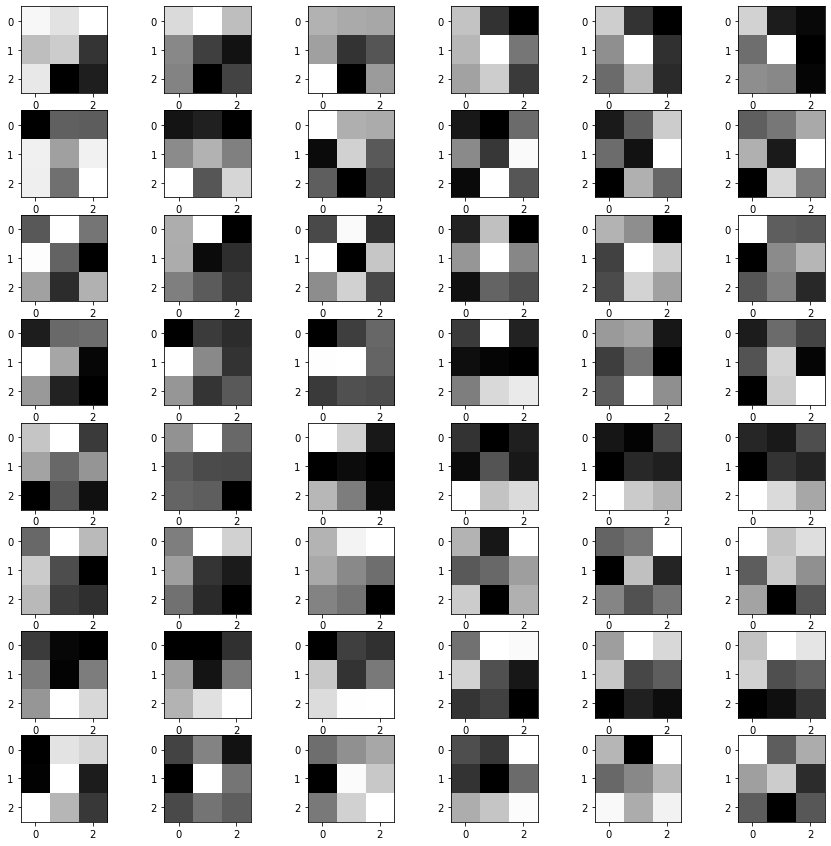

In [69]:
filter_visual()

验证网络

In [70]:
model.eval()

valid_model(EPOCH, model, optimizer)
reValid = valid
valid = []

Valid Epoch / Batch [1 / 10] - Loss: 1.367
Valid Epoch / Batch [1 / 20] - Loss: 1.476
Valid Epoch / Batch [1 / 30] - Loss: 1.256
Valid Epoch / Batch [1 / 40] - Loss: 1.076
Valid Epoch / Batch [1 / 50] - Loss: 1.529
Valid Epoch / Batch [1 / 60] - Loss: 1.253
Valid Epoch / Batch [2 / 10] - Loss: 1.190
Valid Epoch / Batch [2 / 20] - Loss: 1.286
Valid Epoch / Batch [2 / 30] - Loss: 1.087
Valid Epoch / Batch [2 / 40] - Loss: 0.940
Valid Epoch / Batch [2 / 50] - Loss: 1.388
Valid Epoch / Batch [2 / 60] - Loss: 1.124
Valid Epoch / Batch [3 / 10] - Loss: 1.096
Valid Epoch / Batch [3 / 20] - Loss: 1.158
Valid Epoch / Batch [3 / 30] - Loss: 0.958
Valid Epoch / Batch [3 / 40] - Loss: 0.833
Valid Epoch / Batch [3 / 50] - Loss: 1.231
Valid Epoch / Batch [3 / 60] - Loss: 1.008
Valid Epoch / Batch [4 / 10] - Loss: 1.013
Valid Epoch / Batch [4 / 20] - Loss: 1.041
Valid Epoch / Batch [4 / 30] - Loss: 0.840
Valid Epoch / Batch [4 / 40] - Loss: 0.733
Valid Epoch / Batch [4 / 50] - Loss: 1.074
Valid Epoch

训练集准确率

In [71]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

with torch.no_grad():
  for data in train_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    labels_true = np.append(labels_true, labels.cpu().numpy())
    labels_pred = np.append(labels_pred, predicted.cpu().numpy())

    train_accuracy = np.equal(labels_pred, labels_true).mean()

    c = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

accuracy = float(correct) / total
print('Correct: %d' % correct)
print('Total: %d' % total)
print('Train Accuracy: %.4f' % train_accuracy)
print('Accuracy of the model on the train images: %d %%' % (100 * correct / total))

for i in range(10):
  print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

Correct: 3639
Total: 6300
Train Accuracy: 0.5776
Accuracy of the model on the train images: 57 %
Accuracy of baboon: 73 %
Accuracy of banana: 50 %
Accuracy of canoe: 68 %
Accuracy of   cat: 82 %
Accuracy of  desk: 34 %
Accuracy of drill: 55 %
Accuracy of dumbbell: 43 %
Accuracy of football: 44 %
Accuracy of   mug: 48 %
Accuracy of orange: 75 %


In [72]:
labels_true

array([6, 6, 3, ..., 6, 3, 7])

In [73]:
labels_pred

array([5, 0, 7, ..., 6, 3, 6])

测试集准确率

In [74]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    labels_true = np.append(labels_true, labels.cpu().numpy())
    labels_pred = np.append(labels_pred, predicted.cpu().numpy())

    test_accuracy = np.equal(labels_pred, labels_true).mean()

    c = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

accuracy = float(correct) / total
print('Correct: %d' % correct)
print('Total: %d' % total)
print('Test Accuracy: %.4f' % test_accuracy)
print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))

for i in range(10):
  print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

Correct: 870
Total: 1800
Test Accuracy: 0.4833
Accuracy of the model on the test images: 48 %
Accuracy of baboon: 58 %
Accuracy of banana: 57 %
Accuracy of canoe: 62 %
Accuracy of   cat: 78 %
Accuracy of  desk: 28 %
Accuracy of drill: 40 %
Accuracy of dumbbell: 27 %
Accuracy of football: 34 %
Accuracy of   mug: 34 %
Accuracy of orange: 76 %


混淆矩阵图

In [75]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[106.   1.   3.  62.   0.   0.   3.   5.   0.   0.]
 [  6.  89.   1.  28.   0.   4.   3.  11.   8.  38.]
 [ 12.   4. 102.  17.   2.   8.   7.  10.   3.   1.]
 [ 23.   3.   3. 151.   0.   2.   1.   2.   0.   0.]
 [ 10.   2.  19.  17.  47.  27.  22.  12.  15.   2.]
 [ 15.   4.   2.  19.   5.  70.  34.  13.  12.   3.]
 [ 15.   2.   6.  40.   7.  21.  51.  17.  11.   3.]
 [ 26.   3.   6.  51.   2.  15.  18.  59.   6.   3.]
 [ 16.  13.  10.  12.   4.  14.  30.  19.  69.   6.]
 [  1.  31.   2.   2.   1.   7.   3.   2.   1. 126.]]


Normalized confusion matrix
[[106.   1.   3.  62.   0.   0.   3.   5.   0.   0.]
 [  6.  89.   1.  28.   0.   4.   3.  11.   8.  38.]
 [ 12.   4. 102.  17.   2.   8.   7.  10.   3.   1.]
 [ 23.   3.   3. 151.   0.   2.   1.   2.   0.   0.]
 [ 10.   2.  19.  17.  47.  27.  22.  12.  15.   2.]
 [ 15.   4.   2.  19.   5.  70.  34.  13.  12.   3.]
 [ 15.   2.   6.  40.   7.  21.  51.  17.  11.   3.]
 [ 26.   3.   6.  51.   2.  15.  18.  59.   6.   3.]
 [ 16.  13.  10.  12.   4.  14.  30.  19.  69.   6.]
 [  1.  31.   2.   2.   1.   7.   3.   2.   1. 126.]]


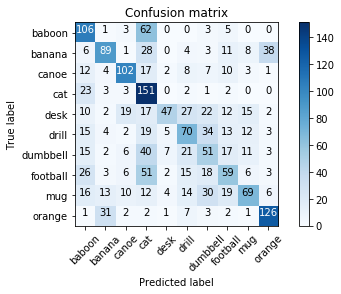

<Figure size 7200x7200 with 0 Axes>

In [76]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')

损失函数图

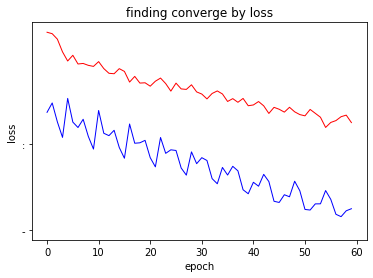

In [77]:
draw_loss(reTrain, reValid)

# 特征图可视化

### 绘制第一层特征图

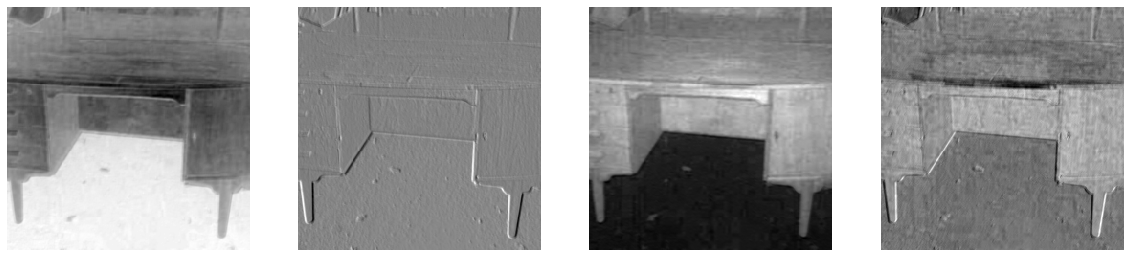

In [78]:
idx = 1000
idy = 500

input_x = ins_dataset_test[idx][0].unsqueeze(0)
input_y = ins_dataset_test[idy][0].unsqueeze(0)
feature_maps_x = model.retrieve_features(input_x.to(device))
feature_maps_y = model.retrieve_features(input_y.to(device))

plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[0][0, i, ...].data.cpu().numpy(), cmap='gray')

### 绘制第二层特征图

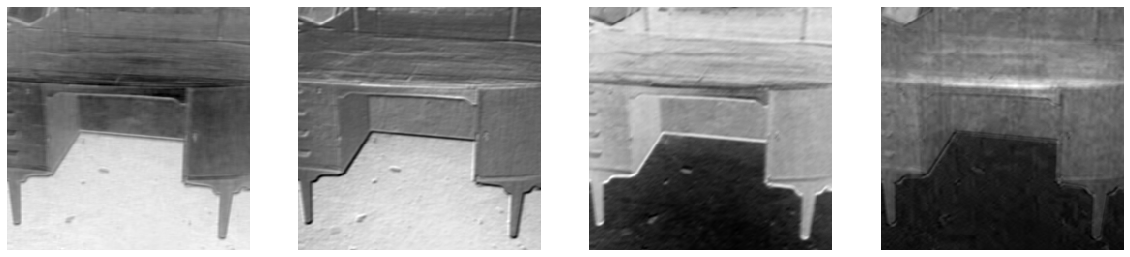

In [79]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(2 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[1][0, i,...].data.cpu().numpy(), cmap='gray')

### 绘制第三层特征图

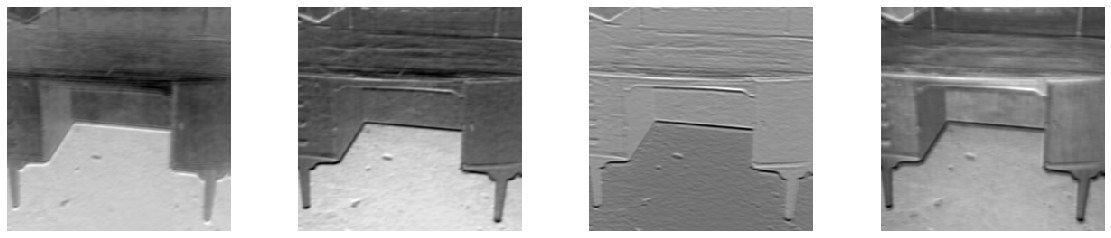

In [80]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(3 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[2][0, i,...].data.cpu().numpy(), cmap='gray')

### 绘制第四层特征图

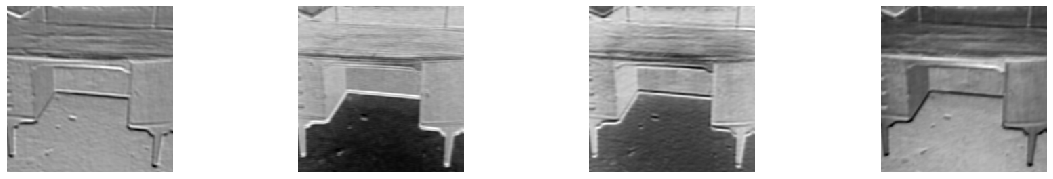

In [81]:
plt.figure(figsize = (20, 14))
for i in range(4):
    plt.subplot(4 ,4 ,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_x[3][0, i,...].data.cpu().numpy(), cmap='gray')

绘制第一层特征图

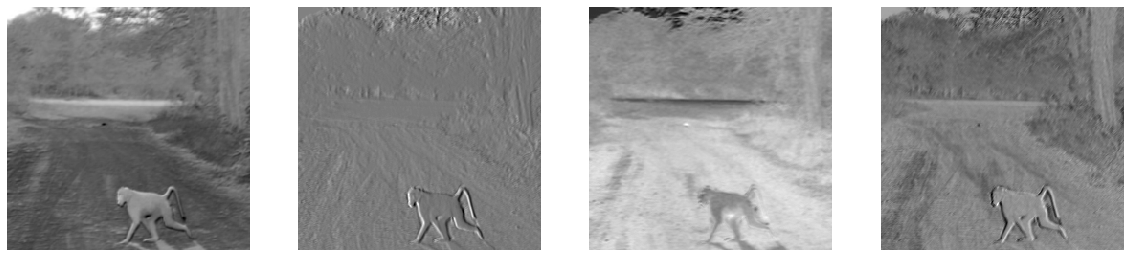

In [82]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[0][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第二层特征图

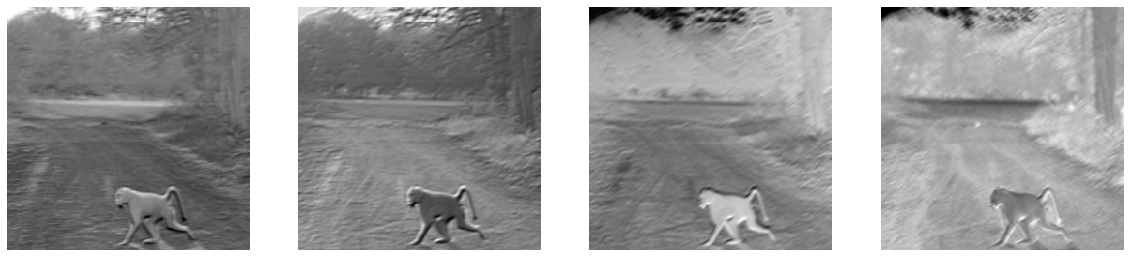

In [83]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[1][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第三层特征图

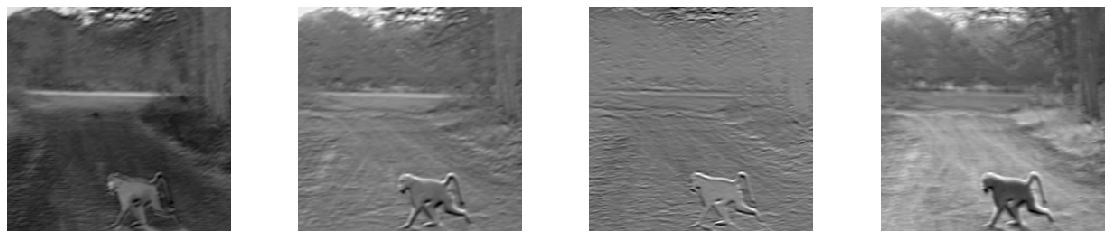

In [84]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[2][0, i, ...].data.cpu().numpy(), cmap='gray')

绘制第四层特征图

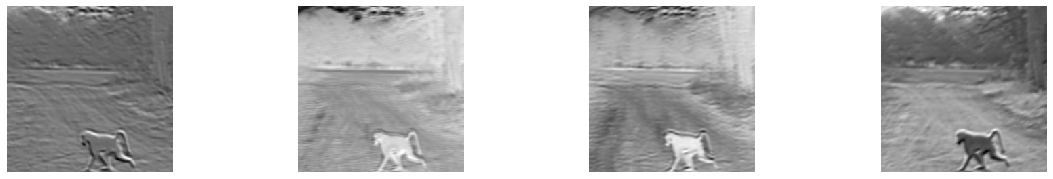

In [85]:
plt.figure(figsize=(20, 14))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(feature_maps_y[3][0, i, ...].data.cpu().numpy(), cmap='gray')

# 提升网络性能

In [86]:
from torchvision import models

final_model = models.resnet18(pretrained = False)

# 冻结预训练网络中的参数
for param in final_model.parameters():
    param.require_grad = False

final_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# from collections import OrderedDict

# classifier = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(25088, 4096)),
#                             ('relu1', nn.ReLU()),
#                             ('fc2', nn.Linear(4096, 1000)),
#                             ('relu2', nn.ReLU()),
#                             ('fc3', nn.Linear(1000, 10)),
#                             ('output', nn.LogSoftmax(dim=1))
# ]))

# final_model.classifier = classifier

定义优化器和损失函数

In [0]:
loss_fn = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr = 0.001)

In [89]:
final_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
final_train = []
final_valid = []

In [91]:
train_model(10, final_model, final_optimizer, 0)

Train Epoch / Batch [1 / 100] - Loss: 2.551
Train Epoch / Batch [1 / 200] - Loss: 2.116
Train Epoch / Batch [1 / 300] - Loss: 2.087
Train Epoch / Batch [1 / 400] - Loss: 1.967
Train Epoch / Batch [1 / 500] - Loss: 2.026
Train Epoch / Batch [1 / 600] - Loss: 1.943
Train Epoch / Batch [2 / 100] - Loss: 1.963
Train Epoch / Batch [2 / 200] - Loss: 1.946
Train Epoch / Batch [2 / 300] - Loss: 1.935
Train Epoch / Batch [2 / 400] - Loss: 1.831
Train Epoch / Batch [2 / 500] - Loss: 1.858
Train Epoch / Batch [2 / 600] - Loss: 1.785
Train Epoch / Batch [3 / 100] - Loss: 1.703
Train Epoch / Batch [3 / 200] - Loss: 1.710
Train Epoch / Batch [3 / 300] - Loss: 1.750
Train Epoch / Batch [3 / 400] - Loss: 1.708
Train Epoch / Batch [3 / 500] - Loss: 1.635
Train Epoch / Batch [3 / 600] - Loss: 1.660
Train Epoch / Batch [4 / 100] - Loss: 1.611
Train Epoch / Batch [4 / 200] - Loss: 1.597
Train Epoch / Batch [4 / 300] - Loss: 1.575
Train Epoch / Batch [4 / 400] - Loss: 1.482
Train Epoch / Batch [4 / 500] - 

In [92]:
valid_model(10, final_model, final_optimizer)

Valid Epoch / Batch [1 / 10] - Loss: 1.109
Valid Epoch / Batch [1 / 20] - Loss: 1.272
Valid Epoch / Batch [1 / 30] - Loss: 1.085
Valid Epoch / Batch [1 / 40] - Loss: 0.915
Valid Epoch / Batch [1 / 50] - Loss: 1.265
Valid Epoch / Batch [1 / 60] - Loss: 0.962
Valid Epoch / Batch [2 / 10] - Loss: 0.793
Valid Epoch / Batch [2 / 20] - Loss: 0.986
Valid Epoch / Batch [2 / 30] - Loss: 0.788
Valid Epoch / Batch [2 / 40] - Loss: 0.741
Valid Epoch / Batch [2 / 50] - Loss: 0.962
Valid Epoch / Batch [2 / 60] - Loss: 0.757
Valid Epoch / Batch [3 / 10] - Loss: 0.609
Valid Epoch / Batch [3 / 20] - Loss: 0.798
Valid Epoch / Batch [3 / 30] - Loss: 0.620
Valid Epoch / Batch [3 / 40] - Loss: 0.584
Valid Epoch / Batch [3 / 50] - Loss: 0.667
Valid Epoch / Batch [3 / 60] - Loss: 0.578
Valid Epoch / Batch [4 / 10] - Loss: 0.465
Valid Epoch / Batch [4 / 20] - Loss: 0.600
Valid Epoch / Batch [4 / 30] - Loss: 0.404
Valid Epoch / Batch [4 / 40] - Loss: 0.389
Valid Epoch / Batch [4 / 50] - Loss: 0.412
Valid Epoch

In [0]:
final_train = train
final_valid = valid
train = []
valid = []

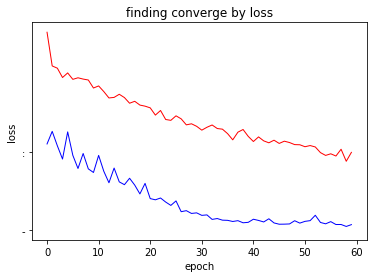

In [94]:
draw_loss(final_train, final_valid)

训练集准确率

In [95]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = final_model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 4212
total: 6300
Accuracy of the network on the images: 66 %
Accuracy of baboon: 75 %
Accuracy of banana: 56 %
Accuracy of canoe: 71 %
Accuracy of   cat: 77 %
Accuracy of  desk: 75 %
Accuracy of drill: 53 %
Accuracy of dumbbell: 50 %
Accuracy of football: 53 %
Accuracy of   mug: 76 %
Accuracy of orange: 78 %


测试集准确率

In [96]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = final_model(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print("correct: %d" % correct)
print("total: %d" % total)
print('Accuracy of the network on the images: %d %%' % (100 * correct / total))

for i in range(10):
    print('Accuracy of %5s: %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

total = 0
correct = 0

correct: 1159
total: 1800
Accuracy of the network on the images: 64 %
Accuracy of baboon: 76 %
Accuracy of banana: 63 %
Accuracy of canoe: 70 %
Accuracy of   cat: 68 %
Accuracy of  desk: 63 %
Accuracy of drill: 46 %
Accuracy of dumbbell: 42 %
Accuracy of football: 56 %
Accuracy of   mug: 73 %
Accuracy of orange: 86 %


混淆矩阵

In [97]:
cm = np.zeros((10, 10))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
# for i in range(10):
    # cm[i] = cm[i] / cm[i].sum()
    # print(cm[i])
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[126.   2.   6.  30.   0.   0.   7.   8.   1.   0.]
 [  9. 111.   4.   5.   6.   4.   5.  10.  11.  23.]
 [  8.   2. 116.   2.   7.   3.   3.  12.  10.   3.]
 [ 18.   1.   4. 144.   3.   1.   2.   7.   5.   0.]
 [  1.   5.   3.   1. 119.   8.   8.   5.  22.   1.]
 [  7.   2.   1.   3.  14.  86.  35.   6.  22.   1.]
 [  6.   2.   0.   6.  17.  26.  76.  14.  25.   1.]
 [ 22.   2.  10.   9.   5.  11.  15.  94.  19.   2.]
 [  3.   4.   1.   4.  10.   2.   8.  18. 135.   8.]
 [  1.   5.   0.   3.   2.   2.   0.   3.   8. 152.]]


Normalized confusion matrix
[[126.   2.   6.  30.   0.   0.   7.   8.   1.   0.]
 [  9. 111.   4.   5.   6.   4.   5.  10.  11.  23.]
 [  8.   2. 116.   2.   7.   3.   3.  12.  10.   3.]
 [ 18.   1.   4. 144.   3.   1.   2.   7.   5.   0.]
 [  1.   5.   3.   1. 119.   8.   8.   5.  22.   1.]
 [  7.   2.   1.   3.  14.  86.  35.   6.  22.   1.]
 [  6.   2.   0.   6.  17.  26.  76.  14.  25.   1.]
 [ 22.   2.  10.   9.   5.  11.  15.  94.  19.   2.]
 [  3.   4.   1.   4.  10.   2.   8.  18. 135.   8.]
 [  1.   5.   0.   3.   2.   2.   0.   3.   8. 152.]]


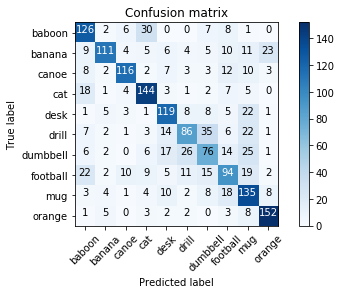

<Figure size 7200x7200 with 0 Axes>

In [98]:
plot_confusion_matrix(cm, class_names, 'Confusion matrix')